In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D,Activation
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.models import Sequential, Model
%matplotlib inline

In [2]:
im_shape = (300,300)
seed = 10
BATCH_SIZE = 32

train_dir = r"C:\Users\25690\Downloads\archive\train"
test_dir = r'C:\Users\25690\Downloads\archive\test'
val_dir = r'C:\Users\25690\Downloads\archive\val'

In [3]:
data_generator = ImageDataGenerator(validation_split=0.2,preprocessing_function=preprocess_input)

val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [4]:
# generate train data
train_generator = data_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# generate validation data
validation_generator = val_data_generator.flow_from_directory(val_dir, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# generate test data
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_generator.flow_from_directory(test_dir, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('classes: '+str(classes))
num_classes = len(classes)

Found 1440 images belonging to 4 classes.
Found 6 images belonging to 4 classes.
Found 771 images belonging to 4 classes.
classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


In [5]:
modelcnn = Sequential()
#add layers of CNN with relu activation function to detect nonlinearity
modelcnn.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=(im_shape[0],im_shape[1],3)))
modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
modelcnn.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
modelcnn.add(Dropout(0.2))
modelcnn.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
modelcnn.add(Flatten())
modelcnn.add(Dense(100, activation='relu'))
modelcnn.add(Dropout(0.2))
modelcnn.add(Dense(num_classes, activation='softmax'))
#see summary of the CNN model
modelcnn.summary()
#compile cnn and set metrics to recall
modelcnn.compile(loss='categorical_crossentropy',optimizer=Adam(), metrics=[tf.keras.metrics.Recall()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 73, 73, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        1

In [6]:
epochs = 10

#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='modelcnn.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,verbose=1)
]

#the training process
history = modelcnn.fit(train_generator, steps_per_epoch=nb_train_samples // BATCH_SIZE, epochs=epochs,
        callbacks = callbacks_list, validation_data=validation_generator, verbose = 1,
                       validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/10
45/45 [==============================] - 38s 697ms/step - loss: 1.3864 - recall: 0.3958
Epoch 2/10
45/45 [==============================] - 28s 624ms/step - loss: 0.4467 - recall: 0.7965
Epoch 3/10
45/45 [==============================] - 28s 619ms/step - loss: 0.2672 - recall: 0.8944
Epoch 4/10
45/45 [==============================] - 29s 659ms/step - loss: 0.2089 - recall: 0.9201
Epoch 5/10
45/45 [==============================] - 29s 636ms/step - loss: 0.1599 - recall: 0.9326
Epoch 6/10
45/45 [==============================] - 28s 624ms/step - loss: 0.1311 - recall: 0.9514
Epoch 7/10
45/45 [==============================] - 27s 587ms/step - loss: 0.0817 - recall: 0.9722
Epoch 8/10
45/45 [==============================] - 29s 642ms/step - loss: 0.0789 - recall: 0.9729
Epoch 9/10
45/45 [==============================] - 29s 645ms/step - loss: 0.0615 - recall: 0.9771
Epoch 10/10
45/45 [==============================] - 29s 632ms/step - loss: 0.0599 - recall: 0.9806


In [7]:
val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

In [8]:
# Load the best model
from tensorflow.keras.models import load_model

score = modelcnn.evaluate_generator(validation_generator)
val_loss.append(score[0])
val_accuracy.append(score[1])
print('\n\nval loss:', score[0])
print('val recall:', score[1])

score = modelcnn.evaluate_generator(test_generator)
print('\ntest loss:', score[0])
print('test recall:', score[1])

test_loss.append(score[0])
test_accuracy.append(score[1])



val loss: 0.06033617630600929
val recall: 1.0

test loss: 1.0322364568710327
test recall: 0.7924773097038269


In [9]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes)

    if normalize:
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_norm = np.around(cm_norm, decimals=2)
        cm_norm[np.isnan(cm_norm)] = 0.0
        cm = cm_norm

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j], ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    fig.tight_layout()
    plt.show()

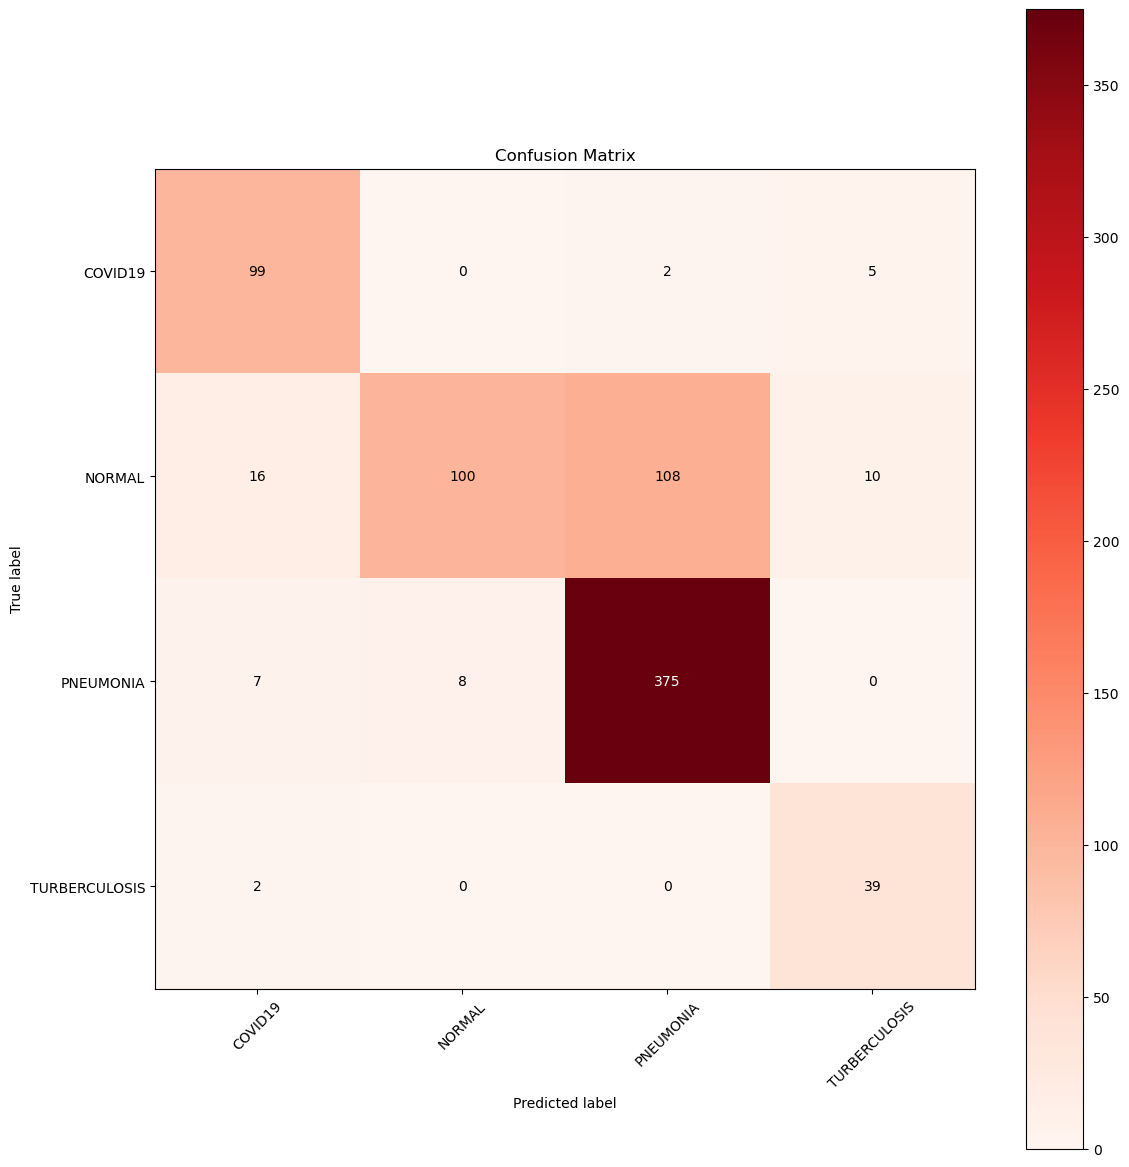

Classification Results
               precision    recall  f1-score   support

      COVID19       0.80      0.93      0.86       106
       NORMAL       0.93      0.43      0.58       234
    PNEUMONIA       0.77      0.96      0.86       390
TURBERCULOSIS       0.72      0.95      0.82        41

     accuracy                           0.80       771
    macro avg       0.80      0.82      0.78       771
 weighted avg       0.82      0.80      0.77       771



In [10]:
from sklearn.metrics import classification_report, confusion_matrix

#generate confution Matrix and classification result
Y_pred = modelcnn.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Results')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [11]:
recall = history.history['recall']
loss = history.history['loss']
epochs = range(len(recall))

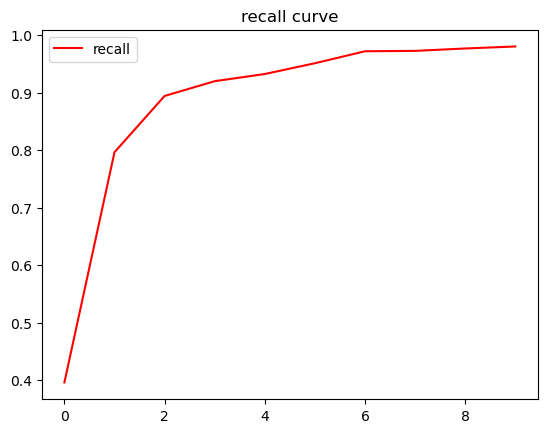

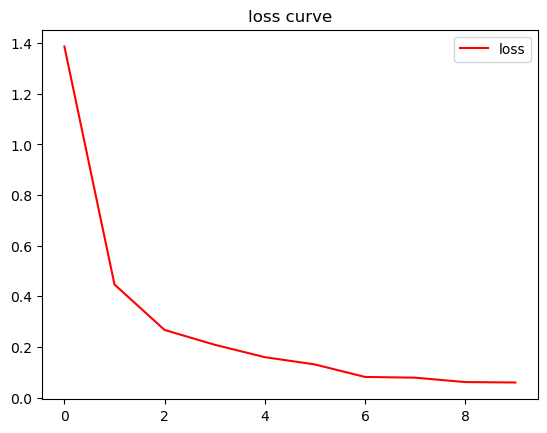

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
plt.plot(epochs,recall,'r',label='recall')
plt.title('recall curve')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'r',label='loss')
plt.title('loss curve')
plt.legend()
plt.figure()
plt.show()